In [11]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

In [12]:
BASE_DIR = Path(r"C:\Users\hp\OneDrive\Desktop\marketing-analytics-python")
DATA_DIR = BASE_DIR / "data"
OUTPUT_DIR = BASE_DIR / "outputs"
CHART_DIR = OUTPUT_DIR / "charts"

In [13]:
OUTPUT_DIR.mkdir(exist_ok=True)
CHART_DIR.mkdir(parents=True, exist_ok=True)

In [14]:
USERS_F     = DATA_DIR / "users.csv"
CAMPAIGNS_F = DATA_DIR / "campaigns.csv"
ADS_F       = DATA_DIR / "ads.csv"
EVENTS_F    = DATA_DIR / "ad_events.csv"

In [15]:
for f in [USERS_F, CAMPAIGNS_F, ADS_F, EVENTS_F]:
    assert f.exists(), f"Dosya bulunamadı: {f}"
print("✔ Dosyalar bulundu ve çıktı klasörleri hazır.")

✔ Dosyalar bulundu ve çıktı klasörleri hazır.


In [16]:
users     = pd.read_csv(USERS_F)
campaigns = pd.read_csv(CAMPAIGNS_F, parse_dates=["start_date","end_date"])
ads       = pd.read_csv(ADS_F)
ad_events = pd.read_csv(EVENTS_F, parse_dates=["timestamp"])

In [17]:
def normalize_cols(df):
    df.columns = [c.strip().lower() for c in df.columns]
    return df

In [18]:
users     = normalize_cols(users)
campaigns = normalize_cols(campaigns)
ads       = normalize_cols(ads)
ad_events = normalize_cols(ad_events)

display(users.head(3))
display(campaigns.head(3))
display(ads.head(3))
display(ad_events.head(3))

,user_id,user_gender,user_age,age_group,country,location,interests
0,a2474,Female,24,18-24,United Kingdom,New Mariomouth,"fitness, health"
1,141e5,Male,21,18-24,Germany,Danielsfort,"food, fitness, lifestyle"
2,34db0,Male,27,25-34,Australia,Vincentchester,"fashion, news"


,campaign_id,name,start_date,end_date,duration_days,total_budget
0,1,Campaign_1_Launch,2025-05-25,2025-07-23,59,24021.32
1,2,Campaign_2_Launch,2025-04-16,2025-07-07,82,79342.41
2,3,Campaign_3_Winter,2025-05-04,2025-06-29,56,14343.25


,ad_id,campaign_id,ad_platform,ad_type,target_gender,target_age_group,target_interests
0,1,28,Facebook,Video,Female,35-44,"art, technology"
1,2,33,Facebook,Stories,All,25-34,"travel, photography"
2,3,20,Instagram,Carousel,All,25-34,technology


,event_id,ad_id,user_id,timestamp,day_of_week,time_of_day,event_type
0,1,197,2359b,2025-07-26 00:19:56,Saturday,Night,Like
1,2,51,f9c67,2025-06-15 08:28:07,Sunday,Morning,Share
2,3,46,5b868,2025-06-27 00:40:02,Friday,Night,Impression


In [19]:
# Event tiplerini normalize et
ad_events["event_type"] = ad_events["event_type"].astype(str).str.strip().str.title()

In [20]:
# Zaman türevleri
ad_events["date"] = ad_events["timestamp"].dt.date
ad_events["hour"] = ad_events["timestamp"].dt.hour
ad_events["dow"]  = ad_events["timestamp"].dt.day_name()

In [21]:
display(ad_events["event_type"].value_counts(dropna=False).head(10))

event_type
Impression    339812
Click          40079
Like           12013
Comment         4108
Purchase        2031
Share           1957
Name: count, dtype: int64

In [22]:
import re

In [23]:
def to_interest_list(x):
    if pd.isna(x):
        return []
    if isinstance(x, list):
        raw = x
    else:
        raw = re.split(r"[;,]", str(x))
    out = []
    for item in raw:
        t = item.strip().lower()
        if not t or t in {"none","null","nan","n/a","-","_"}:
            continue
        out.append(t)
    return out

In [24]:
users["interests_list"]          = users["interests"].apply(to_interest_list)
ads["target_interests_list"]     = ads["target_interests"].apply(to_interest_list)

print("örnek users.interests_list:", users["interests_list"].head(3).to_list())
print("örnek ads.target_interests_list:", ads["target_interests_list"].head(3).to_list())

örnek users.interests_list: [['fitness', 'health'], ['food', 'fitness', 'lifestyle'], ['fashion', 'news']]
örnek ads.target_interests_list: [['art', 'technology'], ['travel', 'photography'], ['technology']]


In [25]:
users_interests = (
    users[["user_id","interests_list"]]
    .explode("interests_list")
    .rename(columns={"interests_list":"interest"})
    .dropna(subset=["interest"])
    .drop_duplicates(["user_id","interest"])
    .reset_index(drop=True)
)

In [26]:
ads_target_interests = (
    ads[["ad_id","target_interests_list"]]
    .explode("target_interests_list")
    .rename(columns={"target_interests_list":"interest"})
    .dropna(subset=["interest"])
    .drop_duplicates(["ad_id","interest"])
    .reset_index(drop=True)
)

In [27]:
print("users_interests şekil:", users_interests.shape)
print("ads_target_interests şekil:", ads_target_interests.shape)

print("\nTop 10 kullanıcı ilgi alanı:")
display(users_interests["interest"].value_counts().head(10))

print("\nTop 10 hedeflenen ilgi alanı:")
display(ads_target_interests["interest"].value_counts().head(10))

users_interests şekil: (19917, 2)
ads_target_interests şekil: (300, 2)

Top 10 kullanıcı ilgi alanı:


interest
fitness       1579
technology    1565
lifestyle     1553
gaming        1551
art           1546
travel        1542
fashion       1536
health        1528
sports        1522
food          1510
Name: count, dtype: int64


Top 10 hedeflenen ilgi alanı:


interest
health         29
finance        28
travel         27
gaming         27
fashion        26
sports         24
news           23
photography    22
art            21
technology     21
Name: count, dtype: int64

In [28]:
users_dedup = users.drop_duplicates(subset=["user_id"])
evt_ads      = ad_events.merge(ads, on="ad_id", how="left")
evt_ads_camp = evt_ads.merge(campaigns, on="campaign_id", how="left")
full         = evt_ads_camp.merge(users_dedup, on="user_id", how="left")

In [29]:
print("Birleşik tablo (full) şekli:", full.shape)
display(full.head(5))

Birleşik tablo (full) şekli: (400000, 29)


,event_id,ad_id,user_id,timestamp,day_of_week,time_of_day,event_type,date,hour,dow,...,end_date,duration_days,total_budget,user_gender,user_age,age_group,country,location,interests,interests_list
0,1,197,2359b,2025-07-26 00:19:56,Saturday,Night,Like,2025-07-26,0,Saturday,...,2025-07-13,49,40094.07,Female,24,18-24,United States,West Shawna,"gaming, food","[gaming, food]"
1,2,51,f9c67,2025-06-15 08:28:07,Sunday,Morning,Share,2025-06-15,8,Sunday,...,2025-06-17,77,44538.87,Female,30,25-34,United States,Meyersland,"photography, finance","[photography, finance]"
2,3,46,5b868,2025-06-27 00:40:02,Friday,Night,Impression,2025-06-27,0,Friday,...,2025-07-21,65,19669.27,Male,20,18-24,United States,Barrerahaven,"fashion, sports, travel","[fashion, sports, travel]"
3,4,166,3d440,2025-06-05 19:20:45,Thursday,Evening,Impression,2025-06-05,19,Thursday,...,2025-06-04,50,39849.94,Female,18,18-24,United States,Lake Angelaland,"food, art","[food, art]"
4,5,52,68f1a,2025-07-22 08:30:29,Tuesday,Morning,Impression,2025-07-22,8,Tuesday,...,2025-07-07,82,79342.41,Male,58,55-65,United Kingdom,Robinsonberg,"finance, lifestyle","[finance, lifestyle]"


In [30]:
ua = users_interests.merge(ads_target_interests, on="interest", how="inner")

In [31]:
ua_counts = (
    ua.groupby(["user_id","ad_id"])
      .size()
      .reset_index(name="interest_match_count")
)

In [32]:
full = full.merge(ua_counts, on=["user_id","ad_id"], how="left")
full["interest_match_count"] = full["interest_match_count"].fillna(0).astype(int)
full["any_interest_match"]   = (full["interest_match_count"] > 0).astype(int)

display(full[["ad_id","user_id","interest_match_count","any_interest_match"]].head(10))

,ad_id,user_id,interest_match_count,any_interest_match
0,197,2359b,1,1
1,51,f9c67,1,1
2,46,5b868,1,1
3,166,3d440,0,0
4,52,68f1a,1,1
5,99,03834,0,0
6,40,23ee4,1,1
7,105,bfadb,0,0
8,107,0124f,0,0
9,6,c025d,1,1


In [33]:
full["is_impression"] = (full["event_type"] == "Impression").astype(int)
full["is_click"]      = (full["event_type"] == "Click").astype(int)
full["is_like"]       = (full["event_type"] == "Like").astype(int)
full["is_share"]      = (full["event_type"] == "Share").astype(int)
full["is_purchase"] = (full["event_type"] == "Purchase").astype(int)
full["is_comment"]    = (full["event_type"] == "Comment").astype(int) if "Comment" in full["event_type"].unique() else 0

In [34]:
print("— Event türü sayımları —")
display(full["event_type"].value_counts())

— Event türü sayımları —


event_type
Impression    339812
Click          40079
Like           12013
Comment         4108
Purchase        2031
Share           1957
Name: count, dtype: int64

In [35]:
print("— Bayrak kolonlarının toplamları —")
display(full[["is_impression","is_click","is_like","is_share","is_comment","is_purchase"]].sum())

— Bayrak kolonlarının toplamları —


is_impression    339812
is_click          40079
is_like           12013
is_share           1957
is_comment         4108
is_purchase        2031
dtype: int64

In [36]:
total_events = len(full)
flag_sum = full[["is_impression","is_click","is_like","is_share","is_comment","is_purchase"]].sum(axis=1).sum()
print(f"Toplam satır: {len(full):,} | Bayrak satır toplamı: {int(flag_sum):,}")

Toplam satır: 400,000 | Bayrak satır toplamı: 400,000


In [37]:
display(full.head(5)[["event_type","is_impression","is_click","is_like","is_share","is_comment","any_interest_match","interest_match_count"]])

,event_type,is_impression,is_click,is_like,is_share,is_comment,any_interest_match,interest_match_count
0,Like,0,0,1,0,0,1,1
1,Share,0,0,0,1,0,1,1
2,Impression,1,0,0,0,0,1,1
3,Impression,1,0,0,0,0,0,0
4,Impression,1,0,0,0,0,1,1


In [38]:
def agg_kpis(df, groupby_cols):
    g = df.groupby(groupby_cols, dropna=False).agg(
        impressions   = ("is_impression","sum"),
        clicks        = ("is_click","sum"),
        likes         = ("is_like","sum"),
        shares        = ("is_share","sum"),
        comments      = ("is_comment","sum"),
        purchases     = ("is_purchase","sum"),   
        users_reached = ("user_id", pd.Series.nunique),
        ads_count     = ("ad_id", pd.Series.nunique)
    ).reset_index()

    g["ctr"] = np.where(g["impressions"] > 0, g["clicks"]/g["impressions"], np.nan)
    g["engagements"] = g[["likes","shares","comments"]].sum(axis=1)
    g["engagement_rate"] = np.where(g["impressions"] > 0, g["engagements"]/g["impressions"], np.nan)
    g["conversion_rate"] = np.where(g["impressions"] > 0, g["purchases"]/g["impressions"], np.nan)  
    return g

In [39]:
camp_kpis = agg_kpis(full, ["campaign_id","name"])
display(camp_kpis.sort_values("conversion_rate", ascending=False).head(10))

,campaign_id,name,impressions,clicks,likes,shares,comments,purchases,users_reached,ads_count,ctr,engagements,engagement_rate,conversion_rate
25,27,Campaign_27_Q3,3323,393,128,22,40,33,3242,2,0.118267,190,0.057177,0.009931
21,23,Campaign_23_Winter,5011,605,181,35,62,42,4445,3,0.120734,278,0.055478,0.008382
29,31,Campaign_31_Summer,5035,589,187,26,65,42,4486,3,0.116981,278,0.055214,0.008342
9,10,Campaign_10_Winter,6661,763,231,38,79,51,5362,4,0.114547,348,0.052244,0.007657
19,21,Campaign_21_Winter,6718,811,244,36,84,49,5426,4,0.120720,364,0.054183,0.007294
10,11,Campaign_11_Q3,5095,618,173,30,54,37,4496,3,0.121295,257,0.050442,0.007262
24,26,Campaign_26_Winter,5124,564,199,28,63,37,4535,3,0.110070,290,0.056596,0.007221
36,38,Campaign_38_Q3,13425,1593,495,89,176,96,7978,8,0.118659,760,0.056611,0.007151
31,33,Campaign_33_Summer,12043,1397,409,75,156,85,7580,7,0.116001,640,0.053143,0.007058
39,41,Campaign_41_Winter,5166,605,162,23,72,35,4535,3,0.117112,257,0.049748,0.006775


In [40]:
camp_platform_type = agg_kpis(full, ["campaign_id","name","ad_platform","ad_type"])
display(camp_platform_type.sort_values("impressions", ascending=False).head(20))

,campaign_id,name,ad_platform,ad_type,impressions,clicks,likes,shares,comments,purchases,users_reached,ads_count,ctr,engagements,engagement_rate,conversion_rate
117,38,Campaign_38_Q3,Facebook,Carousel,6815,771,234,43,85,48,5484,4,0.113133,362,0.053118,0.007043
55,20,Campaign_20_Winter,Facebook,Carousel,5171,666,159,23,52,26,4562,3,0.128795,234,0.045252,0.005028
130,42,Campaign_42_Summer,Facebook,Stories,5110,619,180,36,66,27,4540,3,0.121135,282,0.055186,0.005284
145,47,Campaign_47_Launch,Facebook,Stories,5099,594,183,23,68,28,4462,3,0.116493,274,0.053736,0.005491
70,24,Campaign_24_Summer,Facebook,Stories,5089,620,156,34,56,35,4458,3,0.121831,246,0.048340,0.006878
56,20,Campaign_20_Winter,Facebook,Image,5037,581,176,28,56,28,4428,3,0.115346,260,0.051618,0.005559
45,17,Campaign_17_Launch,Facebook,Image,5018,627,178,37,68,36,4500,3,0.124950,283,0.056397,0.007174
92,30,Campaign_30_Winter,Facebook,Video,5011,634,177,27,63,29,4455,3,0.126522,267,0.053283,0.005787
126,41,Campaign_41_Winter,Facebook,Image,3500,391,102,16,43,27,3360,2,0.111714,161,0.046000,0.007714
102,33,Campaign_33_Summer,Facebook,Stories,3498,397,114,21,45,26,3387,2,0.113493,180,0.051458,0.007433


In [41]:
camp_interests = (
    ads.merge(ads_target_interests, on="ad_id", how="left")
       .merge(campaigns, on="campaign_id", how="left")
       [["campaign_id","name","interest"]]
       .drop_duplicates()
)

print("Her kampanyanın hedeflediği ilgi alanları:")
display(camp_interests.groupby("campaign_id")["interest"].apply(list).reset_index().head(10))

Her kampanyanın hedeflediği ilgi alanları:


,campaign_id,interest
0,1,"[news, finance]"
1,2,"[finance, technology, health, lifestyle, photo..."
2,3,"[gaming, sports, lifestyle, finance, fitness]"
3,4,"[health, fashion, finance, photography, gaming..."
4,5,"[news, art, finance]"
5,6,"[health, food, gaming]"
6,7,"[fashion, health, food]"
7,8,"[health, photography, fitness, travel, fashion..."
8,9,"[fashion, gaming, fitness, sports, health, tec..."
9,10,"[technology, travel, health, sports, fitness]"


In [42]:
camp_country = agg_kpis(full, ["campaign_id","name","country"])
display(camp_country.sort_values("impressions", ascending=False).head(20))

,campaign_id,name,country,impressions,clicks,likes,shares,comments,purchases,users_reached,ads_count,ctr,engagements,engagement_rate,conversion_rate
229,24,Campaign_24_Summer,United States,4146,477,129,23,50,23,2393,8,0.115051,202,0.048722,0.005548
159,17,Campaign_17_Launch,United States,4105,491,146,26,58,40,2390,8,0.119610,230,0.056029,0.009744
409,42,Campaign_42_Summer,United States,4081,450,154,23,55,25,2407,8,0.110267,232,0.056849,0.006126
189,20,Campaign_20_Winter,United States,4039,538,145,20,35,26,2383,8,0.133201,200,0.049517,0.006437
369,38,Campaign_38_Q3,United States,4023,490,151,26,45,27,2385,8,0.121800,222,0.055183,0.006711
319,33,Campaign_33_Summer,United States,3699,450,128,20,44,28,2319,7,0.121655,192,0.051906,0.007570
279,29,Campaign_29_Winter,United States,3592,396,119,24,34,13,2262,7,0.110245,177,0.049276,0.003619
89,9,Campaign_9_Launch,United States,3260,387,110,14,37,15,2140,6,0.118712,161,0.049387,0.004601
39,4,Campaign_4_Summer,United States,3089,370,113,28,28,14,2118,6,0.119780,169,0.054710,0.004532
449,47,Campaign_47_Launch,United States,3051,379,120,20,41,18,2095,6,0.124222,181,0.059325,0.005900


In [43]:
camp_plat = agg_kpis(full, ["campaign_id","name","ad_platform"])
camp_plat = camp_plat.merge(campaigns[["campaign_id","total_budget"]], on="campaign_id", how="left")
display(camp_plat.sort_values("conversion_rate", ascending=False).head(10))


,campaign_id,name,ad_platform,impressions,clicks,likes,shares,comments,purchases,users_reached,ads_count,ctr,engagements,engagement_rate,conversion_rate,total_budget
45,27,Campaign_27_Q3,Instagram,1676,194,74,12,22,18,1827,1,0.115752,108,0.064439,0.010740,12986.30
1,1,Campaign_1_Launch,Instagram,1719,187,74,8,13,17,1806,1,0.108784,95,0.055265,0.009889,24021.32
21,14,Campaign_14_Summer,Facebook,1639,180,62,12,13,15,1749,1,0.109823,87,0.053081,0.009152,39849.94
44,27,Campaign_27_Q3,Facebook,1647,199,54,10,18,15,1752,1,0.120826,82,0.049787,0.009107,12986.30
37,23,Campaign_23_Winter,Instagram,3371,429,129,18,35,29,3301,2,0.127262,182,0.053990,0.008603,26001.67
51,31,Campaign_31_Summer,Instagram,3400,395,122,13,44,29,3312,2,0.116176,179,0.052647,0.008529,72208.34
16,10,Campaign_10_Winter,Instagram,1678,176,55,8,14,14,1772,1,0.104887,77,0.045888,0.008343,19669.27
33,21,Campaign_21_Winter,Instagram,1688,214,54,9,25,14,1797,1,0.126777,88,0.052133,0.008294,37290.81
50,31,Campaign_31_Summer,Facebook,1635,194,65,13,21,13,1744,1,0.118654,99,0.060550,0.007951,72208.34
36,23,Campaign_23_Winter,Facebook,1640,176,52,17,27,13,1765,1,0.107317,96,0.058537,0.007927,26001.67


In [44]:
camp_interests_all = (
    ads.merge(ads_target_interests, on="ad_id", how="left")
       .merge(campaigns, on="campaign_id", how="left")
       [["campaign_id","interest"]]
       .drop_duplicates()
       .groupby("campaign_id")["interest"]
       .apply(lambda x: sorted(set([i for i in x if pd.notna(i)])))
       .reset_index()
)


camp_plat = camp_plat.merge(camp_interests_all, on="campaign_id", how="left")

In [45]:
top_conv = camp_plat.sort_values("conversion_rate", ascending=False).head(15)
display(top_conv[["campaign_id","name","ad_platform","total_budget",
                  "purchases","conversion_rate","interest"]])

,campaign_id,name,ad_platform,total_budget,purchases,conversion_rate,interest
45,27,Campaign_27_Q3,Instagram,12986.30,18,0.010740,"[finance, fitness, technology, travel]"
1,1,Campaign_1_Launch,Instagram,24021.32,17,0.009889,"[finance, news]"
21,14,Campaign_14_Summer,Facebook,39849.94,15,0.009152,"[fashion, news]"
44,27,Campaign_27_Q3,Facebook,12986.30,15,0.009107,"[finance, fitness, technology, travel]"
37,23,Campaign_23_Winter,Instagram,26001.67,29,0.008603,"[finance, fitness, lifestyle, news, technology]"
51,31,Campaign_31_Summer,Instagram,72208.34,29,0.008529,"[art, fashion, health, lifestyle]"
16,10,Campaign_10_Winter,Instagram,19669.27,14,0.008343,"[fitness, health, sports, technology, travel]"
33,21,Campaign_21_Winter,Instagram,37290.81,14,0.008294,"[art, fashion, finance, health, lifestyle]"
50,31,Campaign_31_Summer,Facebook,72208.34,13,0.007951,"[art, fashion, health, lifestyle]"
36,23,Campaign_23_Winter,Facebook,26001.67,13,0.007927,"[finance, fitness, lifestyle, news, technology]"


In [46]:
camp_plat["purchase_per_kusd"] = camp_plat["purchases"] / (camp_plat["total_budget"]/1000)

roi_top = camp_plat.sort_values("purchase_per_kusd", ascending=False).head(15)
print("== En yüksek ROI (Purchases per 1K$ budget) kampanyaları ==")
display(roi_top[["campaign_id","name","ad_platform","total_budget","purchases","purchase_per_kusd"]])

== En yüksek ROI (Purchases per 1K$ budget) kampanyaları ==


,campaign_id,name,ad_platform,total_budget,purchases,purchase_per_kusd
70,42,Campaign_42_Summer,Facebook,7918.04,52,6.567282
4,3,Campaign_3_Winter,Facebook,14343.25,41,2.858487
72,44,Campaign_44_Q3,Instagram,15914.87,39,2.450538
71,42,Campaign_42_Summer,Instagram,7918.04,15,1.894408
15,10,Campaign_10_Winter,Facebook,19669.27,37,1.881107
47,29,Campaign_29_Winter,Facebook,19773.66,37,1.871176
57,34,Campaign_34_Winter,Instagram,26104.30,42,1.608930
19,13,Campaign_13_Winter,Facebook,21855.42,35,1.601433
45,27,Campaign_27_Q3,Instagram,12986.30,18,1.386076
20,13,Campaign_13_Winter,Instagram,21855.42,29,1.326902


In [47]:
camp_plat["post_click_cr"] = np.where(camp_plat["clicks"]>0, camp_plat["purchases"]/camp_plat["clicks"], np.nan)

funnel_top = camp_plat.sort_values("post_click_cr", ascending=False).head(15)
print("== En yüksek Post-Click Conversion kampanyaları ==")
display(funnel_top[["campaign_id","name","ad_platform","clicks","purchases","post_click_cr","conversion_rate"]])

== En yüksek Post-Click Conversion kampanyaları ==


,campaign_id,name,ad_platform,clicks,purchases,post_click_cr,conversion_rate
45,27,Campaign_27_Q3,Instagram,194,18,0.092784,0.010740
1,1,Campaign_1_Launch,Instagram,187,17,0.090909,0.009889
21,14,Campaign_14_Summer,Facebook,180,15,0.083333,0.009152
16,10,Campaign_10_Winter,Instagram,176,14,0.079545,0.008343
44,27,Campaign_27_Q3,Facebook,199,15,0.075377,0.009107
36,23,Campaign_23_Winter,Facebook,176,13,0.073864,0.007927
51,31,Campaign_31_Summer,Instagram,395,29,0.073418,0.008529
42,26,Campaign_26_Winter,Facebook,182,13,0.071429,0.007688
68,41,Campaign_41_Winter,Facebook,391,27,0.069054,0.007714
37,23,Campaign_23_Winter,Instagram,429,29,0.067599,0.008603


In [48]:
camp_multi_plat = camp_plat.groupby("campaign_id").filter(lambda x: len(x)>1)
camp_multi_plat = camp_multi_plat.sort_values(["campaign_id","conversion_rate"], ascending=False)

print("== Birden çok platformda yayınlanan kampanyalar ==")
display(camp_multi_plat[["campaign_id","name","ad_platform","total_budget","purchases","conversion_rate"]].head(20))

== Birden çok platformda yayınlanan kampanyalar ==


,campaign_id,name,ad_platform,total_budget,purchases,conversion_rate
81,49,Campaign_49_Winter,Facebook,28962.34,9,0.005319
82,49,Campaign_49_Winter,Instagram,28962.34,9,0.005178
79,48,Campaign_48_Winter,Facebook,13842.07,10,0.005967
80,48,Campaign_48_Winter,Instagram,13842.07,7,0.004132
78,47,Campaign_47_Launch,Instagram,69493.36,26,0.007711
77,47,Campaign_47_Launch,Facebook,69493.36,37,0.005359
75,46,Campaign_46_Winter,Facebook,94023.76,30,0.004409
76,46,Campaign_46_Winter,Instagram,94023.76,6,0.003505
73,45,Campaign_45_Summer,Facebook,53303.55,10,0.005952
74,45,Campaign_45_Summer,Instagram,53303.55,9,0.005412


In [49]:
demo_kpis = agg_kpis(full, ["age_group","user_gender"])
demo_top = demo_kpis.sort_values("conversion_rate", ascending=False)
print("== Demografi bazlı conversion rate ==")
display(demo_top.head(15))

== Demografi bazlı conversion rate ==


,age_group,user_gender,impressions,clicks,likes,shares,comments,purchases,users_reached,ads_count,ctr,engagements,engagement_rate,conversion_rate
14,45-54,Other,1166,142,52,9,18,13,35,200,0.121784,79,0.067753,0.011149
16,55-65,Male,1551,177,71,5,16,13,46,200,0.114120,92,0.059317,0.008382
9,35-44,Female,16721,2019,570,105,212,125,500,200,0.120746,887,0.053047,0.007476
12,45-54,Female,4029,487,142,19,38,26,115,200,0.120874,199,0.049392,0.006453
8,25-34,Other,14879,1780,521,83,191,96,436,200,0.119632,795,0.053431,0.006452
3,18-24,Female,36540,4284,1300,206,414,222,1071,200,0.117241,1920,0.052545,0.006076
4,18-24,Male,59340,6976,2088,345,707,359,1736,200,0.117560,3140,0.052915,0.006050
7,25-34,Male,77727,9124,2757,436,934,466,2271,200,0.117385,4127,0.053096,0.005995
6,25-34,Female,48071,5763,1651,278,589,286,1406,200,0.119885,2518,0.052381,0.005950
1,16-17,Male,16177,1884,606,82,213,94,483,200,0.116462,901,0.055696,0.005811


In [50]:
geo_conv = agg_kpis(full, ["country"])
geo_top = geo_conv.sort_values("conversion_rate", ascending=False)
print("== Ülke bazlı conversion rate ==")
display(geo_top.head(15))

== Ülke bazlı conversion rate ==


,country,impressions,clicks,likes,shares,comments,purchases,users_reached,ads_count,ctr,engagements,engagement_rate,conversion_rate
6,Japan,16598,1940,560,96,215,124,487,200,0.116882,871,0.052476,0.007471
7,Mexico,17518,2038,608,103,210,125,508,200,0.116337,921,0.052574,0.007136
9,United States,102447,12134,3627,596,1206,654,3002,200,0.118442,5429,0.052993,0.006384
5,India,31909,3849,1154,169,392,189,943,200,0.120624,1715,0.053747,0.005923
2,Canada,34088,4031,1260,193,383,197,994,200,0.118253,1836,0.053861,0.005779
1,Brazil,20778,2418,767,130,239,118,605,200,0.116373,1136,0.054673,0.005679
8,United Kingdom,51211,5966,1762,294,617,288,1502,200,0.116498,2673,0.052196,0.005624
4,Germany,28114,3299,955,170,373,151,822,200,0.117344,1498,0.053283,0.005371
0,Australia,24153,2905,841,129,309,123,711,200,0.120275,1279,0.052954,0.005093
3,France,12996,1499,479,77,164,62,376,200,0.115343,720,0.055402,0.004771


In [51]:
match_conv = agg_kpis(full, ["any_interest_match"])
print("== Interest-match vs Non-match kullanıcıların conversion performance ==")
display(match_conv)

== Interest-match vs Non-match kullanıcıların conversion performance ==


,any_interest_match,impressions,clicks,likes,shares,comments,purchases,users_reached,ads_count,ctr,engagements,engagement_rate,conversion_rate
0,0,263735,31229,9334,1509,3177,1574,9950,200,0.118411,14020,0.053159,0.005968
1,1,76077,8850,2679,448,931,457,9898,200,0.116330,4058,0.053341,0.006007


In [52]:
tod_conv = agg_kpis(full, ["hour"])
dow_conv = agg_kpis(full, ["dow"])

print("== Saat bazlı conversion rate ==")
display(tod_conv.sort_values("conversion_rate", ascending=False).head(10))

print("\n== Gün bazlı conversion rate ==")
display(dow_conv.sort_values("conversion_rate", ascending=False))

== Saat bazlı conversion rate ==


,hour,impressions,clicks,likes,shares,comments,purchases,users_reached,ads_count,ctr,engagements,engagement_rate,conversion_rate
7,7,13971,1649,506,64,167,107,7988,200,0.118030,737,0.052752,0.007659
0,0,14052,1713,481,70,168,103,8122,200,0.121904,719,0.051167,0.007330
17,17,14171,1681,515,67,158,100,8072,200,0.118623,740,0.052219,0.007057
22,22,14039,1677,520,79,165,99,8032,200,0.119453,764,0.054420,0.007052
2,2,14324,1689,509,92,163,93,8108,200,0.117914,764,0.053337,0.006493
18,18,14193,1625,511,73,189,90,8063,200,0.114493,773,0.054463,0.006341
6,6,14026,1729,463,78,177,87,8068,200,0.123271,718,0.051191,0.006203
10,10,14154,1654,470,90,177,87,8086,200,0.116857,737,0.052070,0.006147
4,4,14064,1693,500,89,166,85,8074,200,0.120378,755,0.053683,0.006044
19,19,14108,1722,516,103,159,85,8076,200,0.122058,778,0.055146,0.006025



== Gün bazlı conversion rate ==


,dow,impressions,clicks,likes,shares,comments,purchases,users_reached,ads_count,ctr,engagements,engagement_rate,conversion_rate
4,Thursday,48598,5626,1726,283,601,314,9914,200,0.115766,2610,0.053706,0.006461
0,Friday,48759,5828,1638,270,600,308,9922,200,0.119527,2508,0.051437,0.006317
2,Saturday,48460,5704,1712,288,568,295,9912,200,0.117705,2568,0.052992,0.006087
1,Monday,48597,5668,1782,315,596,292,9917,200,0.116633,2693,0.055415,0.006009
3,Sunday,48426,5755,1672,256,600,281,9915,200,0.118841,2528,0.052203,0.005803
6,Wednesday,48498,5730,1750,288,562,273,9918,200,0.118149,2600,0.053610,0.005629
5,Tuesday,48474,5768,1733,257,581,268,9915,200,0.118992,2571,0.053039,0.005529


In [53]:
camp_total = agg_kpis(full, ["campaign_id","name"])
camp_total = camp_total.sort_values("purchases", ascending=False)
camp_total["cum_purchases"] = camp_total["purchases"].cumsum()
camp_total["cum_perc"] = camp_total["cum_purchases"] / camp_total["purchases"].sum()

print("== Pareto analizi (top campaigns) ==")
display(camp_total.head(20))

== Pareto analizi (top campaigns) ==


,campaign_id,name,impressions,clicks,likes,shares,comments,purchases,users_reached,ads_count,ctr,engagements,engagement_rate,conversion_rate,cum_purchases,cum_perc
36,38,Campaign_38_Q3,13425,1593,495,89,176,96,7978,8,0.118659,760,0.056611,0.007151,96,0.047267
15,17,Campaign_17_Launch,13506,1646,470,91,180,91,7880,8,0.121872,741,0.054865,0.006738,187,0.092073
31,33,Campaign_33_Summer,12043,1397,409,75,156,85,7580,7,0.116001,640,0.053143,0.007058,272,0.133924
22,24,Campaign_24_Summer,13638,1573,451,87,159,81,7935,8,0.115339,697,0.051107,0.005939,353,0.173806
18,20,Campaign_20_Winter,13607,1658,459,72,156,73,7966,8,0.121849,687,0.050489,0.005365,426,0.209749
32,34,Campaign_34_Winter,10205,1241,348,54,105,68,6961,6,0.121607,507,0.049682,0.006663,494,0.243230
40,42,Campaign_42_Summer,13671,1596,465,74,157,67,7953,8,0.116743,696,0.050911,0.004901,561,0.276219
12,13,Campaign_13_Winter,10331,1210,374,62,132,64,7002,6,0.117123,568,0.054980,0.006195,625,0.307730
44,47,Campaign_47_Launch,10276,1198,365,55,136,63,6951,6,0.116582,556,0.054107,0.006131,688,0.338749
8,9,Campaign_9_Launch,10343,1223,347,42,123,61,7016,6,0.118244,512,0.049502,0.005898,749,0.368784


In [54]:
colors = ['#f8f4d9','#c4b05a','#8f7f2a','#6b5500'] 
plt.rcParams.update({
    "axes.facecolor": "#f5f5f5",
    "figure.facecolor": "#f5f5f5",
    "axes.edgecolor": "#333",
    "axes.labelcolor": "#333",
    "xtick.color": "#333",
    "ytick.color": "#333",
    "axes.titlesize": 20,
    "axes.titleweight": "bold",
    "axes.labelsize": 14,
    "legend.frameon": True,
    "legend.edgecolor": "#333",
    "font.size": 12
})

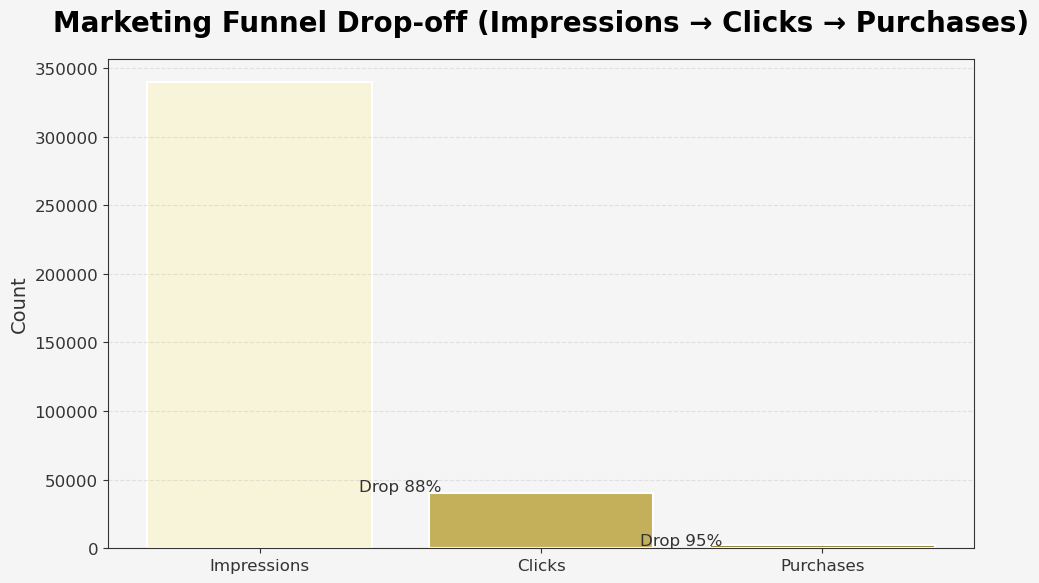

In [55]:
funnel = pd.Series({
    "Impressions": full["is_impression"].sum(),
    "Clicks": full["is_click"].sum(),
    "Purchases": full["is_purchase"].sum()
})

fig, ax = plt.subplots(figsize=(10,6))
bars = ax.bar(funnel.index, funnel.values, color=colors, edgecolor="white", linewidth=1.5)

# Drop oranları
drop1 = 1 - funnel["Clicks"]/funnel["Impressions"]
drop2 = 1 - funnel["Purchases"]/funnel["Clicks"]

ax.annotate(f"Drop {drop1:.0%}", xy=(0.5, funnel["Clicks"]*1.05), ha="center", color="#333")
ax.annotate(f"Drop {drop2:.0%}", xy=(1.5, funnel["Purchases"]*1.05), ha="center", color="#333")

ax.set_title("Marketing Funnel Drop-off (Impressions → Clicks → Purchases)", pad=20)
ax.set_ylabel("Count")
ax.grid(axis="y", linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()


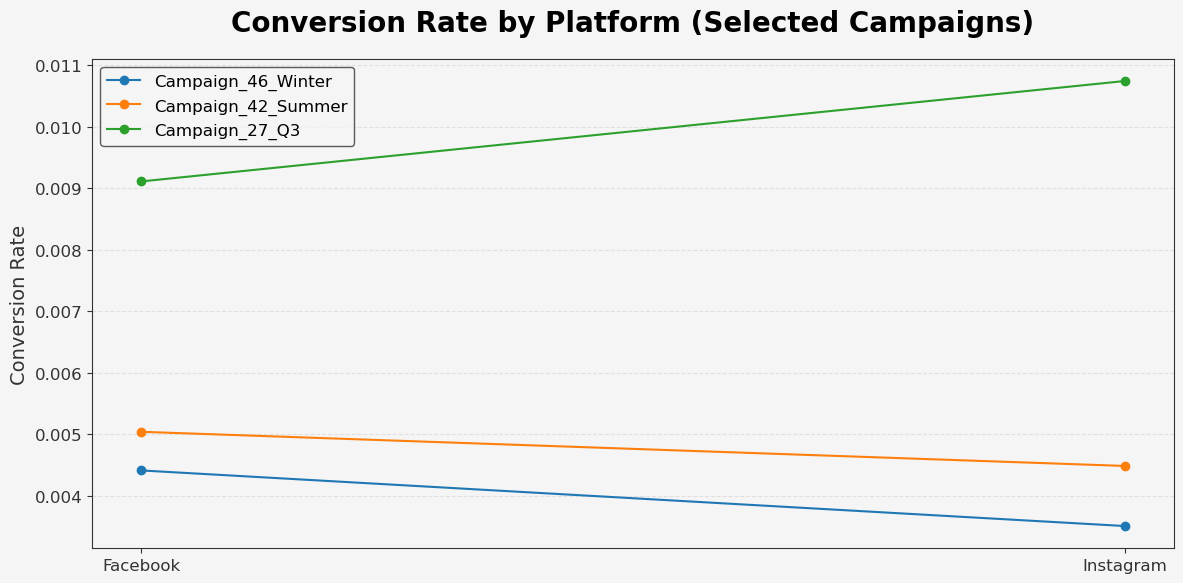

In [56]:
multi_plat = camp_multi_plat[camp_multi_plat["campaign_id"].isin([27,42,46])]
fig, ax = plt.subplots(figsize=(12,6))

for camp in multi_plat["campaign_id"].unique():
    subset = multi_plat[multi_plat["campaign_id"]==camp]
    ax.plot(subset["ad_platform"], subset["conversion_rate"], 
            marker="o", label=subset["name"].iloc[0])

ax.set_title("Conversion Rate by Platform (Selected Campaigns)", pad=20)
ax.set_ylabel("Conversion Rate")
ax.grid(axis="y", linestyle="--", alpha=0.3)
ax.legend()
plt.tight_layout()
plt.show()

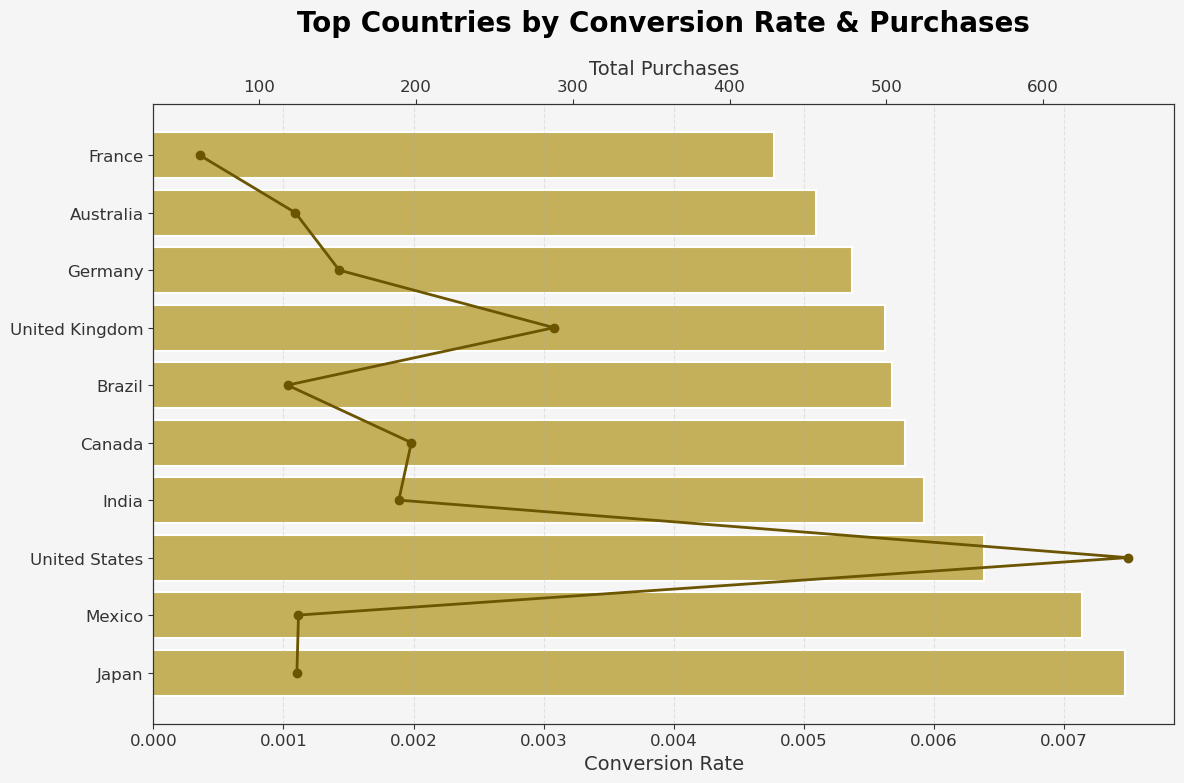

In [57]:
top_countries = geo_top.head(10)

fig, ax1 = plt.subplots(figsize=(12,8))
ax2 = ax1.twiny()

ax1.barh(top_countries["country"], top_countries["conversion_rate"], 
         color=colors[1], edgecolor="white", linewidth=1.5)
ax2.plot(top_countries["purchases"], top_countries["country"], 
         marker="o", color=colors[3], linewidth=2)

ax1.set_xlabel("Conversion Rate")
ax2.set_xlabel("Total Purchases")
ax1.set_title("Top Countries by Conversion Rate & Purchases", pad=20)
ax1.grid(axis="x", linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()

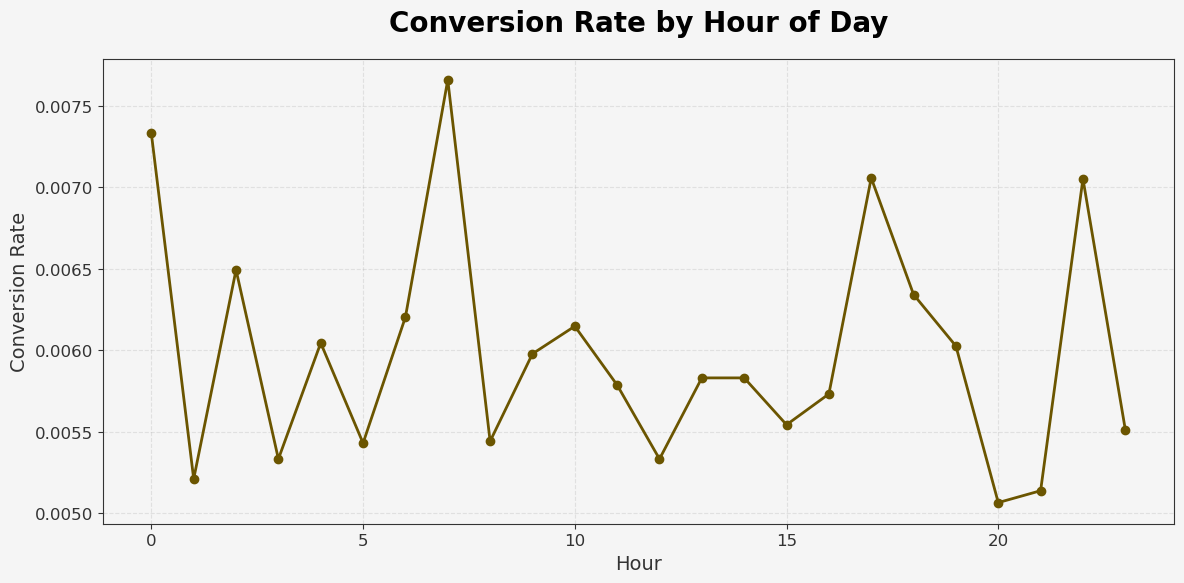

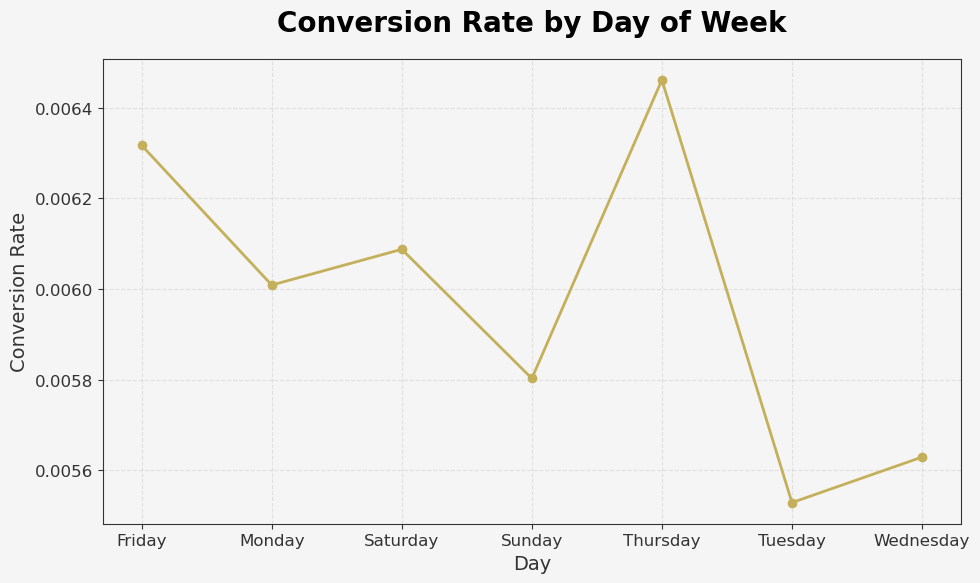

In [58]:
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(tod_conv["hour"], tod_conv["conversion_rate"], 
        marker="o", color=colors[3], linewidth=2)
ax.set_title("Conversion Rate by Hour of Day", pad=20)
ax.set_xlabel("Hour"); ax.set_ylabel("Conversion Rate")
ax.grid(linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()


fig, ax = plt.subplots(figsize=(10,6))
ax.plot(dow_conv["dow"], dow_conv["conversion_rate"], 
        marker="o", color=colors[1], linewidth=2)
ax.set_title("Conversion Rate by Day of Week", pad=20)
ax.set_xlabel("Day"); ax.set_ylabel("Conversion Rate")
ax.grid(linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()

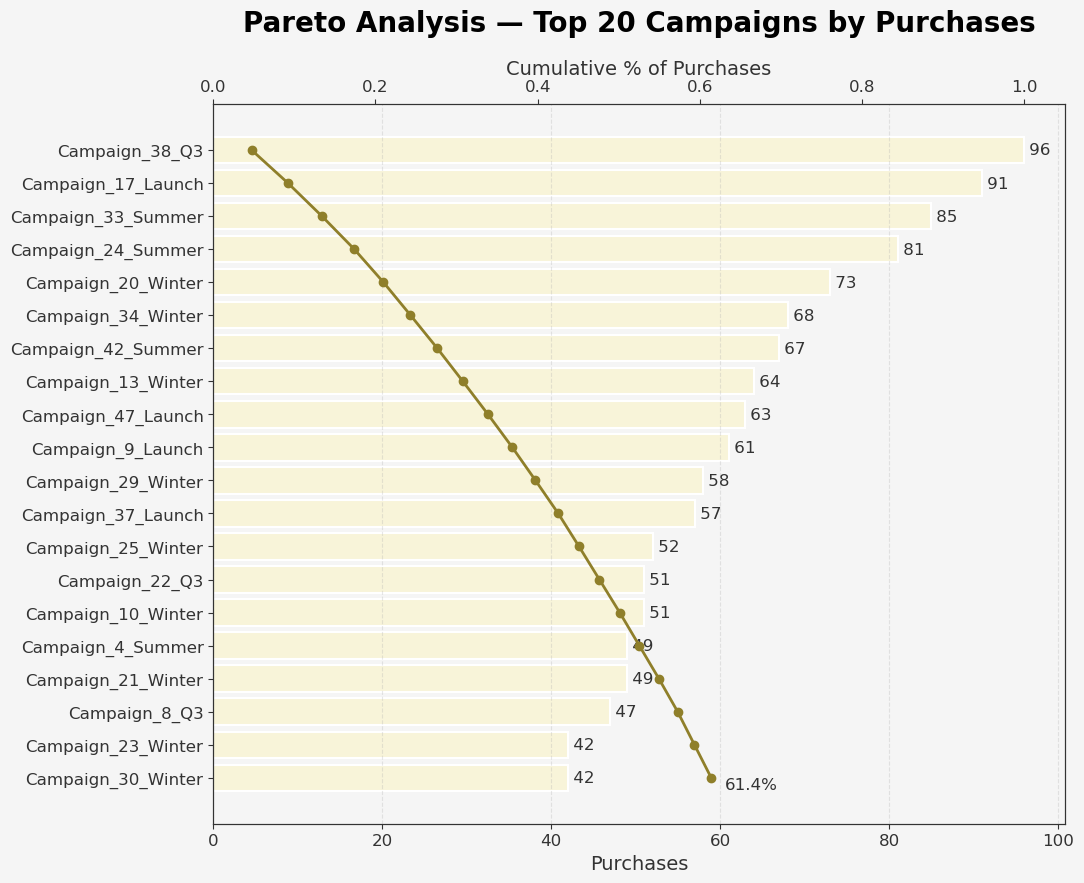

In [59]:
if "camp_total" not in globals():
    camp_total = agg_kpis(full, ["campaign_id","name"]).sort_values("purchases", ascending=False)
    camp_total["cum_purchases"] = camp_total["purchases"].cumsum()
    camp_total["cum_perc"] = camp_total["cum_purchases"] / camp_total["purchases"].sum()

top20 = camp_total.head(20).copy()
labels = top20["name"]

fig, ax1 = plt.subplots(figsize=(11, 9))
ax2 = ax1.twiny()

bars = ax1.barh(labels, top20["purchases"],
                color=colors[0], edgecolor="white", linewidth=1.5)

ax1.invert_yaxis()
ax2.plot(top20["cum_perc"], labels,
         marker="o", color=colors[2], linewidth=2)

ax1.set_xlabel("Purchases")
ax2.set_xlabel("Cumulative % of Purchases")
ax1.set_title("Pareto Analysis — Top 20 Campaigns by Purchases", pad=20)

ax1.grid(axis="x", linestyle="--", alpha=0.3)
ax2.set_xlim(0, 1.05)

for y, v in enumerate(top20["purchases"]):
    ax1.text(v, y, f" {int(v)}", va="center", ha="left", color="#333")

ax2.annotate(f"{top20['cum_perc'].iloc[-1]*100:.1f}%",
             xy=(top20["cum_perc"].iloc[-1], labels.iloc[-1]),
             xytext=(10, -8), textcoords="offset points", color="#333")

plt.tight_layout()
plt.savefig(CHART_DIR / "pareto_top20_purchases.png", dpi=150)
plt.show()


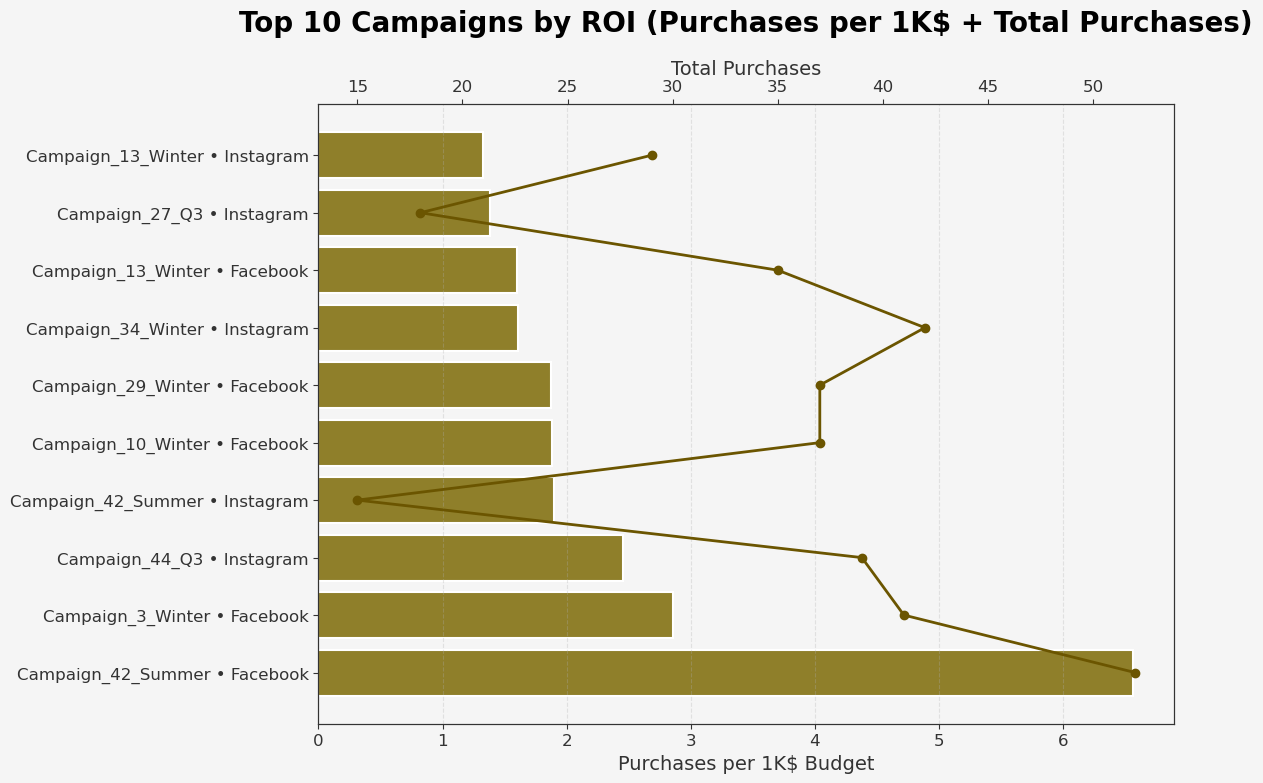

In [60]:
top_roi = camp_plat.sort_values("purchase_per_kusd", ascending=False).head(10)

fig, ax1 = plt.subplots(figsize=(12,8))
ax2 = ax1.twiny()

# Bar chart: Purchases per 1K$
ax1.barh(top_roi["name"] + " • " + top_roi["ad_platform"], 
         top_roi["purchase_per_kusd"], 
         color=colors[2], edgecolor="white", linewidth=1.5)

# Line chart: Total Purchases
ax2.plot(top_roi["purchases"], 
         top_roi["name"] + " • " + top_roi["ad_platform"], 
         marker="o", color=colors[3], linewidth=2)

ax1.set_xlabel("Purchases per 1K$ Budget")
ax2.set_xlabel("Total Purchases")
ax1.set_title("Top 10 Campaigns by ROI (Purchases per 1K$ + Total Purchases)", pad=20)

ax1.grid(axis="x", linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()